# MINDD - 1st Assignment

### Jorge Martins - 1050497
### Patrícia Vicente - 1050532


## Main objective of this assignment

The objective of this assignment is to build predictive models in order to identify the probability of hotel booking cancellations. 
Using data from various hotel clients, key factors will be analyzed and by uncovering patterns and relationships, insights can be gained in order to forecast cancellations, helping hotels minimize financial losses associated with cancellations.

## Necessary library imports

In this section, all the necessary libraries to perform the analysis of the given dataset are imported.
This libraries cover a range of tools for data manipulation, visualization, preprocessing, model training, and evaluation.
Packages for handling imbalanced data (SMOTETomek), feature selection, various classification models and ensemble methods are also included here.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import chi2
from scipy.stats import f_oneway

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

from imblearn.combine import SMOTETomek
from collections import Counter

# Supressing the warning messages
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import StackingClassifier

## Data Exploration

In this section it will be performed the statistic analysis of the dataset, which includes summary statistics, size and data types of each column in the dataset. It will also be checked if there are any missing values as well as the consistency of the columns.

This step is crucial, since it improves the understandig of the dataset, helps to identify potential problems (like missing data and outliers), guides feature selection and preprocessing decisions, and informs the choice of models and evaluation techniques.

In [ ]:
# Load the dataset
df = pd.read_csv('hotel_booking.csv')

# Show the first few rows
#print(df.head(30))

# Show summary statistics
print(df.describe())

# Check types for all the columns
print(df.dtypes)

# Check number of lines/columns
print(df.shape)

# Check number of elements
print(df.size)

# Check columns name
print(df.columns)

# Data types and missing values
print(df.info())

def check_column_type_consistency(data, column):
    # Get the type of each element in the column
    types = data[column].map(type)
    # Check if there is only one unique type
    return types.nunique() == 1

# Check if the column is consistent
for col in df.columns:
    if not check_column_type_consistency(df, col):
        print(col)

         is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000            

## Data Cleaning

This process helps identifying and correct errors, inconsistencies, and inaccuracies in the dataset to ensure it's accuracy, consistency, and that is ready for following analysis and modeling.

This is a critical step as the quality of the data directly impacts the quality of the insights or models.

### Checking and treating missing data

In this section we will check for missing values and treat them accordingly.

If in a small number:
- ignore records with missing values
- manually fill in the missing values

Fill in with common values:
- mode for categorical data
- median for ordered values

Irrelevant columns will be dropped, since they are not useful for the analysis.

One of the factors used to check if a column is irrelevant or not is high percentage of missing values. In this scenario, the Company column has 112593 null entries out of 119,390, meaning it has a 94.3% missing rate, therefore useless in this analysis.

Another criteria is personal information which is irrelevant for the analysis and based on this the columns Name, Email, Phone-number and Credit card will be dropped.

In [3]:
# Check for missing values 
print(df.isnull().sum())

# Treating missing data 
# Categorical variable with a great amout of missing data
df.fillna({'country' : 'Unknown'}, inplace=True)
# for 'country' in df.select_dtypes(include=['object']).columns:
#     df['country'].fillna(df['country'].mode()[0], inplace=True)

# Continuous variable with small number of missing data
df.fillna({'children' : 0}, inplace=True)

#The column 'company' has a lot of missing data, so we will drop it
df.drop('company', axis=1, inplace=True)

# Columns 'name', 'email', 'phone-number' and 'credit_card' are not relevant for the analysis, so we will drop them
df.drop(['name', 'email', 'phone-number', 'credit_card'], axis=1, inplace=True)

# Column 'reservation_status' will be dropped because it's redundant, since we have 'is_canceled' column
# It only has three possible values, which are 'Check-Out', 'Canceled' and 'No-Show' and the last two correspond 
# always to a cancellation and the first one to a successful reservation
df.drop('reservation_status', axis=1, inplace=True)

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

### Addressing the NaN values in column "Agent"

Missing data can lead to biased results or errors in machine learning models, therefore it is crucial to treat this values.

In [4]:
# # Threshold for high correlation
# threshold = 0.5

# Calculate the correlation matrix


# Get the correlation of the 'agent' column with other columns
agent_corr = df['agent'].corr(df['is_canceled'])

print("Correlation of 'agent' column with 'is_canceled' column:", agent_corr)

# # Check if any correlation is above the threshold
# high_corr = agent_corr[agent_corr.abs() > threshold]

# print("Correlations of 'agent' column with other columns:")
# print(agent_corr)
# print("\nColumns strongly correlated with 'agent' (threshold > 0.5):")
# print(high_corr)

Correlation of 'agent' column with 'is_canceled' column: -0.08311415905369247


Due to a poor correlation with every other column and specially with the is_canceled (aprox. -0.0831) which is our target variable, the best course of action to treat this column due to his big amount of null entries and very poor correlation is to delete it in orther to improve the model and analysis.

In [5]:
df.drop('agent', axis=1, inplace=True)

print(df.isnull().sum())

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

### Checking for outliers

Here it will be performed an analysis on the existance of outliers in the columns of the dataset.

The presence of outliers can distort analysis and predictions, and it must be handled in order for a successful training of prediction models.

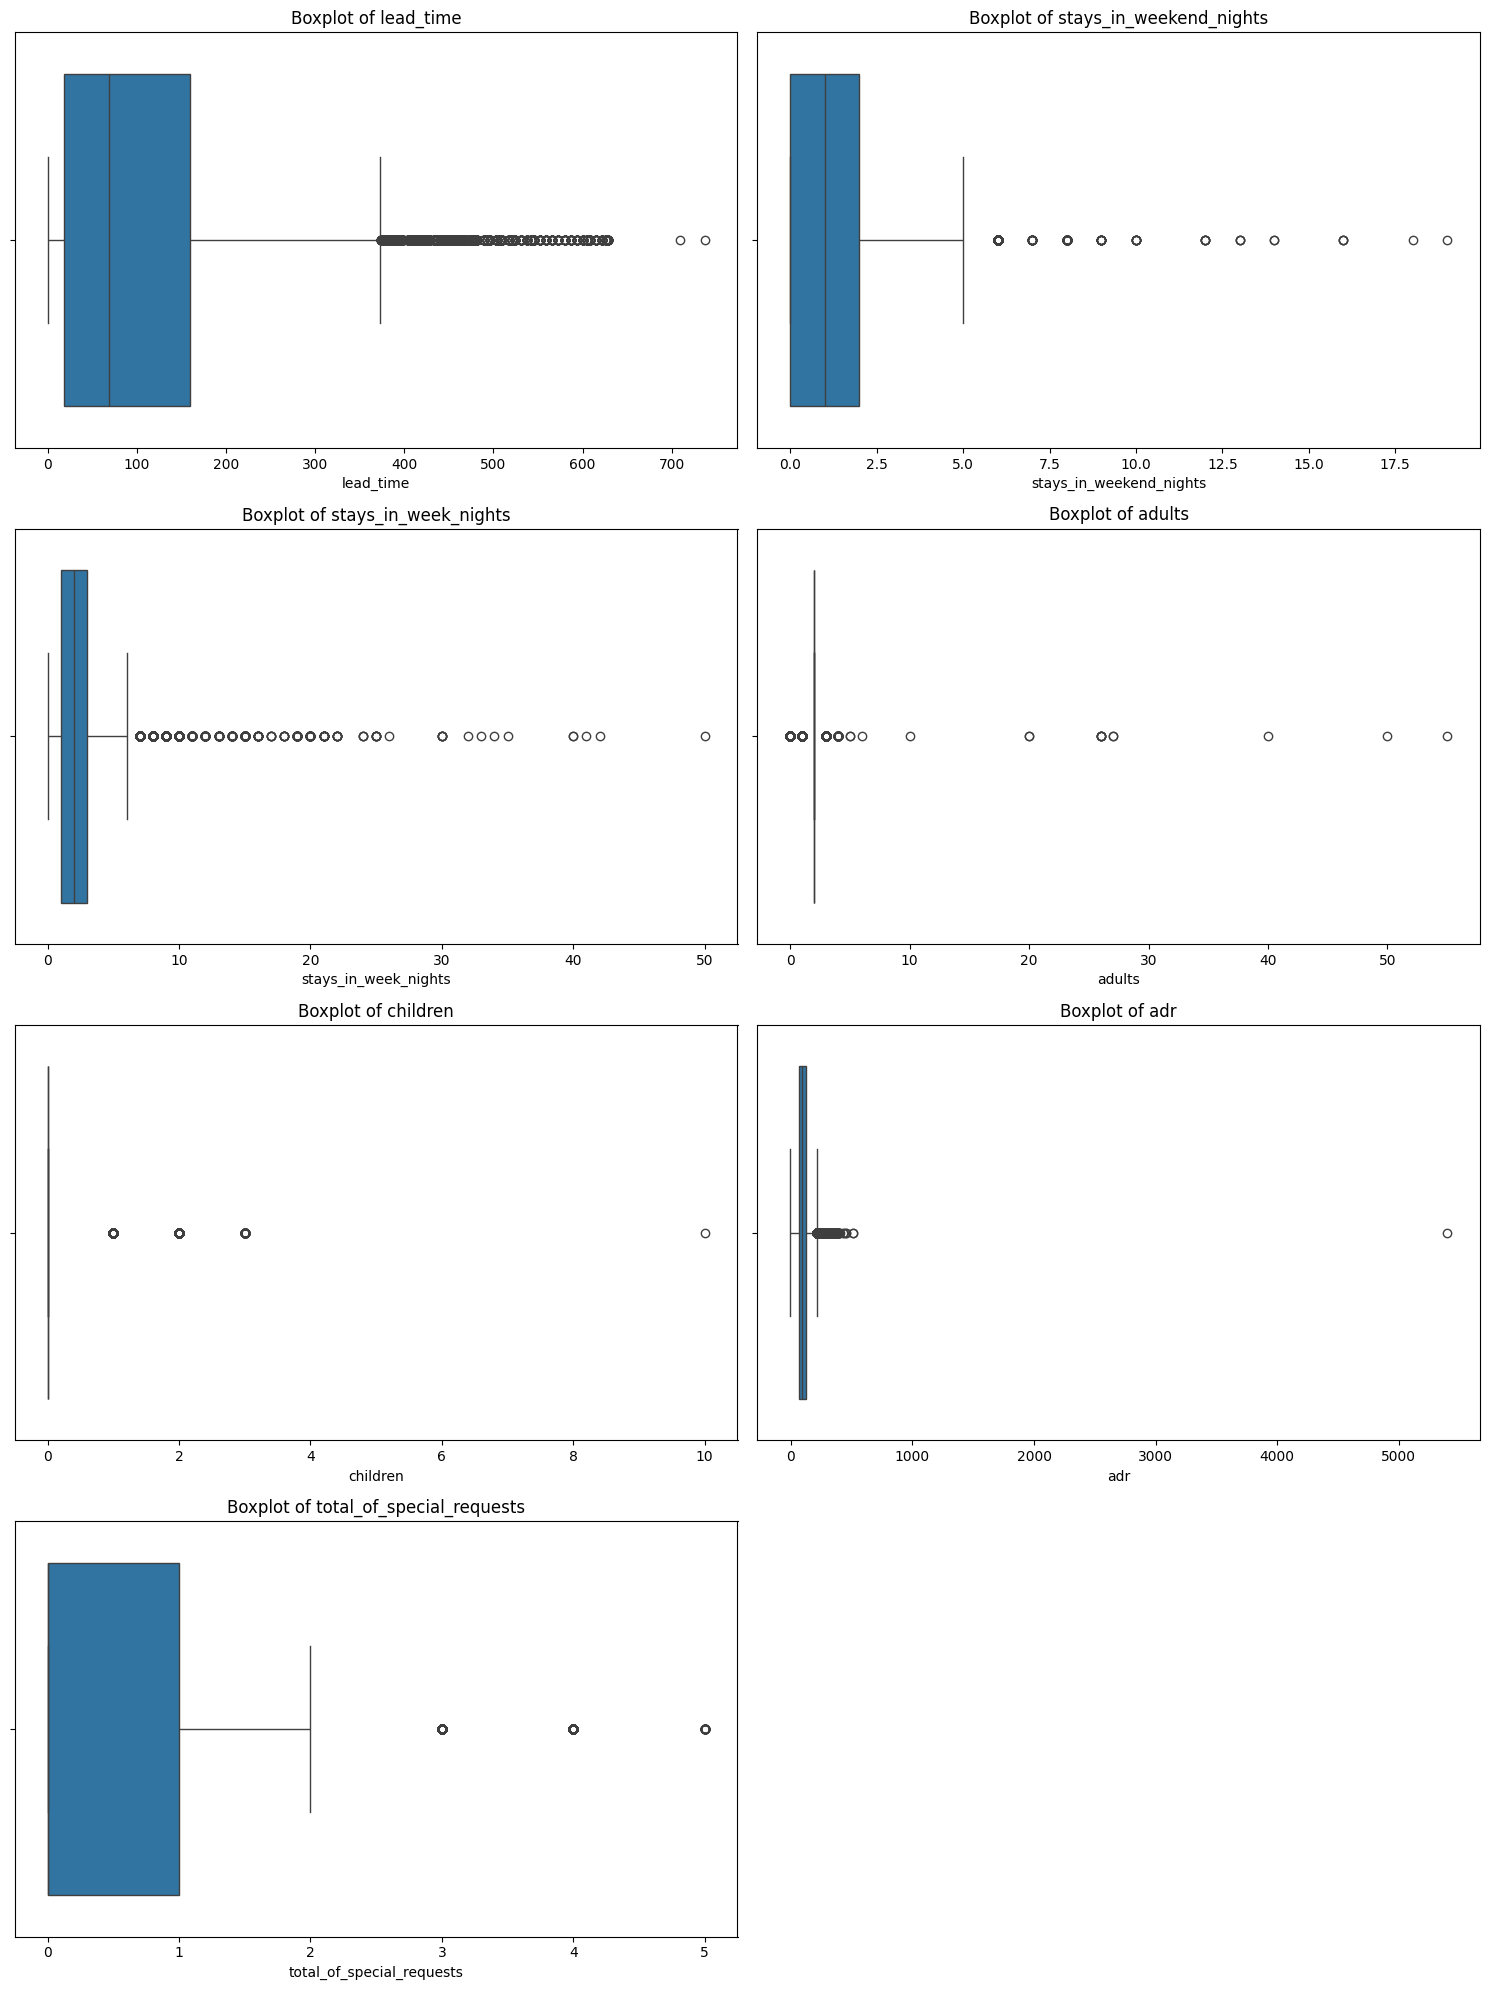

In [6]:
# Checking outliers through boxplot
# List of columns to check for outliers
columns_to_check = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'adr', 'total_of_special_requests']

# Plotting boxplots for each column in a 4x2 matrix
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

for i, column in enumerate(columns_to_check):
    row = i // 2
    col = i % 2
    sns.boxplot(x=column, data=df, ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {column}')

# Remove any empty subplots
for j in range(i + 1, 8):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

### Removing outliers

In [7]:
# Checking outlier through Tukey's Method(IQR) for specific columns
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 2.5 * IQR # The upper bound is increased to 2.5 to avoid removing too many outliers
        initial_count = df.shape[0]
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        final_count = df.shape[0]
        outliers_removed = initial_count - final_count
        print(f"Column: {column}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}, Outliers Removed: {outliers_removed}")
    return df

# Remove outliers from specified columns
# Columns 'adults' and 'children' have outliers but  it makes no sense to remove them due to the high volume 
# of data that would be lost
columns_to_remove = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adr', 'total_of_special_requests']  

df = remove_outliers(df, columns_to_remove)

print(df.shape)

Column: lead_time, Lower Bound: -195.0, Upper Bound: 515.0, Outliers Removed: 411
Column: stays_in_weekend_nights, Lower Bound: -3.0, Upper Bound: 7.0, Outliers Removed: 92
Column: stays_in_week_nights, Lower Bound: -2.0, Upper Bound: 8.0, Outliers Removed: 1576
Column: adr, Lower Bound: -14.0, Upper Bound: 266.0, Outliers Removed: 777
Column: total_of_special_requests, Lower Bound: -1.5, Upper Bound: 3.5, Outliers Removed: 355
(116179, 29)


After analysis of the outliers found in the above features of the dataset, it was decided the best course of action would be to remove outliers from columns 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adr' and 'total_of_special_requests'. Due to the importance and high volume of outliers found in columns 'adults' and 'children', the decision to keep this outliers was made, since they improved the prediction models evaluation and results.

## Standardize Data Formats

Dataset atributes with dates will be transformed into a numerical format for better handling and data processing.

In [8]:
# Converting 'arrival_date_month' to numerical format
df['arrival_date_month'] = df['arrival_date_month'].map({
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
})

# Convert reservation_status_date to datetime
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Extract year, month, and day and create new columns
df['reservation_status_date_year'] = df['reservation_status_date'].dt.year
df['reservation_status_date_month'] = df['reservation_status_date'].dt.month
df['reservation_status_date_day'] = df['reservation_status_date'].dt.day

# Ensure the new columns are of int datatype
df['reservation_status_date_year'] = df['reservation_status_date_year'].astype(int)
df['reservation_status_date_month'] = df['reservation_status_date_month'].astype(int)
df['reservation_status_date_day'] = df['reservation_status_date_day'].astype(int)

# Drop the original reservation_status_date column if no longer needed
df.drop('reservation_status_date', axis=1, inplace=True)

# print(df[['reservation_status_date_year', 'reservation_status_date_month', 'reservation_status_date_day']].head())

## Enconding and Scaling Features

In this step, categorical features will be converted into numerical, in order to improve the model's ability to learn from the data. They will be normalized as well so that they're on the same scale, which is crucial for algorithms that rely on Gradient Descent (like Logistic Regression and Neural Networks). This helps with faster convergence and better performance.

In [9]:
# Encoding some categorical features using LabelEncoder
label_encoders = {}
categorical_columns = ['hotel', 'market_segment', 'distribution_channel', 
                       'customer_type', 'deposit_type', 'meal', 'country',
                       'reserved_room_type', 'assigned_room_type']

df_encoded = df.copy()

for column in categorical_columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le

#display(df_encoded[categorical_columns].head())

## Correlation Matrix

In this section we will check for the coefficient correlation between multiple variables in a dataset. The correlation matrix helps to understand the relationships between variables, identifying patterns, dependencies, or redundancies in the data.

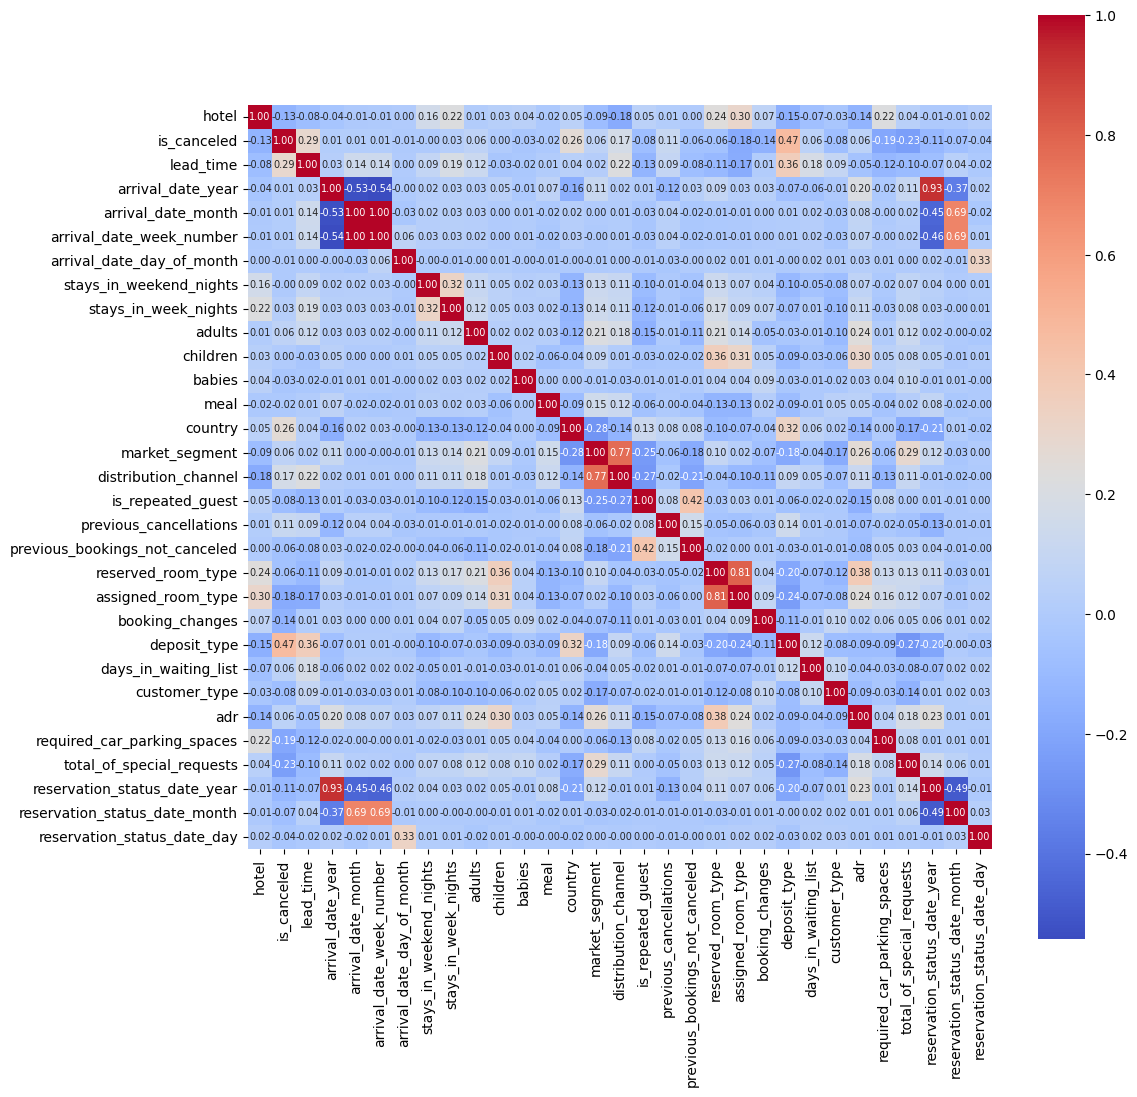

In [10]:
# Compute the correlation matrix
plt.figure(figsize=(12, 12))
corr_matrix = df_encoded.corr()
sns.heatmap(corr_matrix, annot=True, square=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 7})
plt.show()


### Dropping 'arrival_date_year' and 'assigned_room_type' based on very high correlation with other attributes

Since reservation_status_date_year and arrival_date_year have a high leval of correlation of 0.93, which suggests they carry similar information, the logical choice for optimization in both efficacy and efficiency of further results is to remove one of them. The same applies to 'assigned_room_type' and 'reserved_room_type' and to 'arrival_adte_week_number' and 'arrival_date_month'.

In [11]:
# Drop 'arrival_date_year' because it's highly correlated with 'reservation_status_year'
df_encoded.drop('arrival_date_year', axis=1, inplace=True)

# Drop 'assigned_room_type' because it's highly correlated with 'reserved_room_type'
df_encoded.drop('assigned_room_type', axis=1, inplace=True)
categorical_columns.remove('assigned_room_type')

# Drop 'arrival_date_week_number' because it's highly correlated with 'arrival_date_month'
df_encoded.drop('arrival_date_week_number', axis=1, inplace=True)

## Applying filter methods (ANOVA and Chi-Square)

ANOVA and Chi-Square are filter methods used in feature selection.

`ANOVA` 
- is suitable for continuous variables and a categorical target
- selects features whose p-value is bigger than 0.05

`Chi-Square`
- is used to determine the association between categorical variables and
categorical target
- features with large chi-square statistic or small p-values have strong
associations with the target

In [12]:
def chi_square_test(data, target, categorical_columns):
    # Select only the categorical columns
    categorical_features = data[categorical_columns]

    # Extract the target column
    target_data = data[target]

    # Apply Chi-Square test
    chi_scores = chi2(categorical_features, target_data)

    # Create a DataFrame to display the results
    chi2_results = pd.DataFrame({'Feature': categorical_columns, 'Chi2 Score': chi_scores[0], 'P-value': chi_scores[1]})

    # Display the results
    return chi2_results.sort_values(by='Chi2 Score', ascending=False).reset_index(drop=True)

def anova(data, target):
    # Select only the numerical columns
    numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove the target column from the list of numerical features
    if target in numerical_features:
        numerical_features.remove(target)
    
    anova_results = []
    
    for feature in numerical_features:
        # Perform ANOVA
        groups = [data[data[target] == value][feature] for value in data[target].unique()]
        f_val, p_val = f_oneway(*groups)
        anova_results.append({'Feature': feature, 'F-value': f_val, 'P-value': p_val})
    
    # Convert the results to a DataFrame for better readability
    anova_df = pd.DataFrame(anova_results)
    return anova_df.sort_values(by='F-value', ascending=False).reset_index(drop=True)

# Run Chi-Square test on categorical attributes
chi2_results = chi_square_test(df_encoded, 'is_canceled', categorical_columns)
display(chi2_results)

# Run ANOVA on numerical attributes
numerical_df_encoded = df_encoded.drop(columns=categorical_columns)
anova_results = anova(numerical_df_encoded, 'is_canceled')
display(anova_results)


,Feature,Chi2 Score,P-value
0,country,174962.455232,0.000000e+00
1,deposit_type,22905.076116,0.000000e+00
2,hotel,1400.917801,1.327361e-306
3,reserved_room_type,1224.281456,3.223332e-268
4,distribution_channel,1057.899829,4.669595e-232
5,market_segment,137.486972,9.436028e-32
6,customer_type,99.315115,2.153581e-23
7,meal,61.156334,5.271789e-15


,Feature,F-value,P-value
0,lead_time,10997.481773,0.000000e+00
1,total_of_special_requests,6675.231530,0.000000e+00
2,required_car_parking_spaces,4551.421641,0.000000e+00
3,booking_changes,2456.734391,0.000000e+00
4,reservation_status_date_year,1505.713856,0.000000e+00
5,previous_cancellations,1461.423948,9.061297e-318
6,is_repeated_guest,826.776491,3.530493e-181
7,reservation_status_date_month,597.860240,1.054949e-131
8,adults,460.181964,6.926875e-102
9,previous_bookings_not_canceled,380.961950,1.050940e-84


### Removal of features based on ANOVA and Chi-Square results

Based on the results obtained with ANOVA and Chi-Square methods, it was found that atributes 'arrival_date_day_of_month', 'children' and 'stays_in_week_nights' are irrelevant due to high p-values. This indicates multicollinearity, where two or more features are highly correlated, so they can be dropped from the dataset to achieve the best performance and more stable and reliable models.

In [13]:
# Drop 'arrival_date_day_of_month', 'children' and 'stays_in_week_nights' because they have high p-values
df_encoded.drop(['arrival_date_day_of_month', 'children', 'stays_in_week_nights'], axis=1, inplace=True)

## Updated correlation matrix

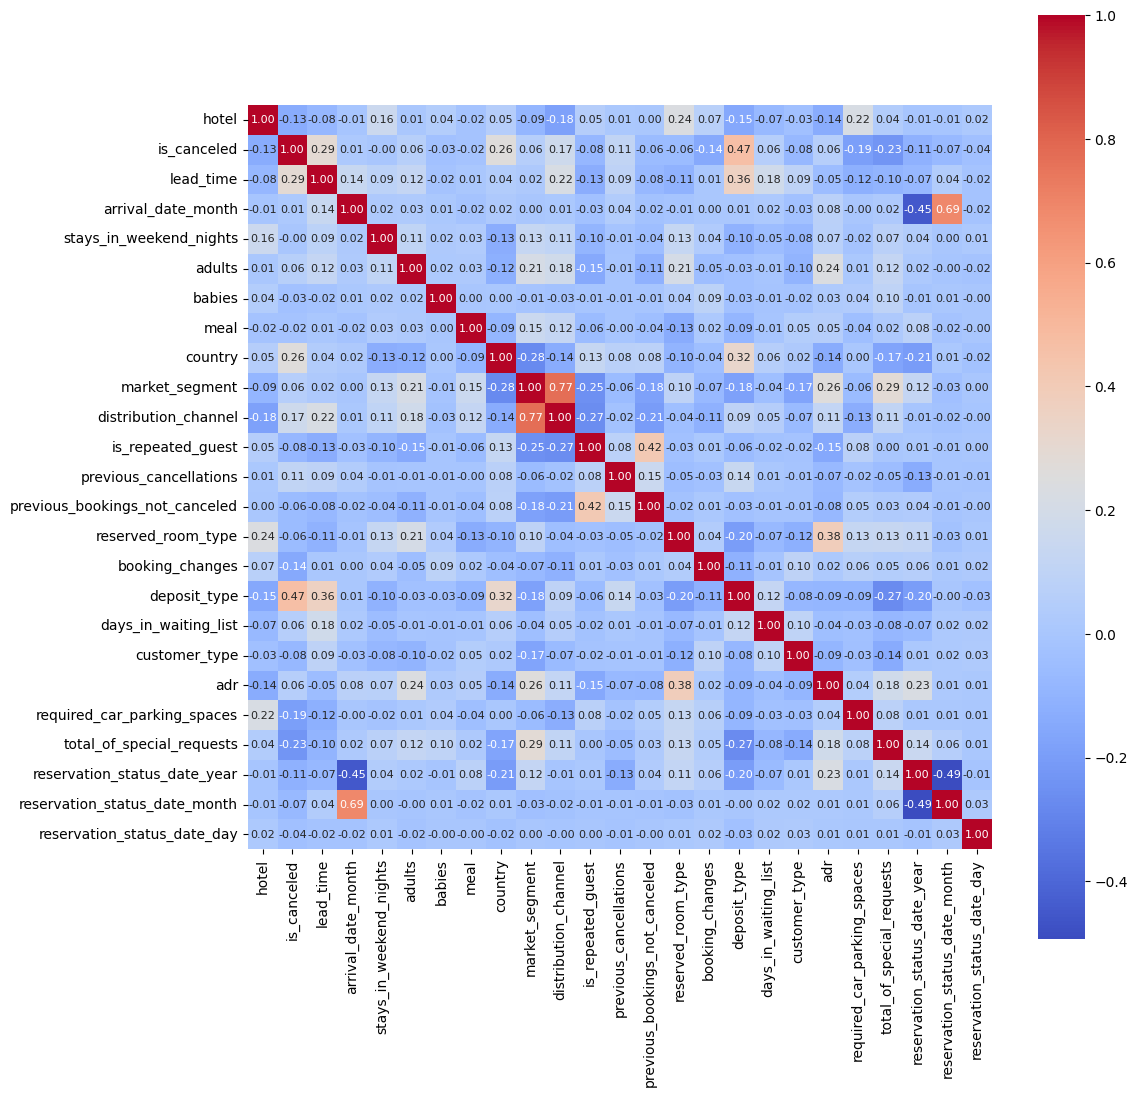

In [14]:
# Compute the correlation matrix
plt.figure(figsize=(12, 12))
corr_matrix = df_encoded.corr()
sns.heatmap(corr_matrix, annot=True, square=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.show()

## Bivariate Analysis

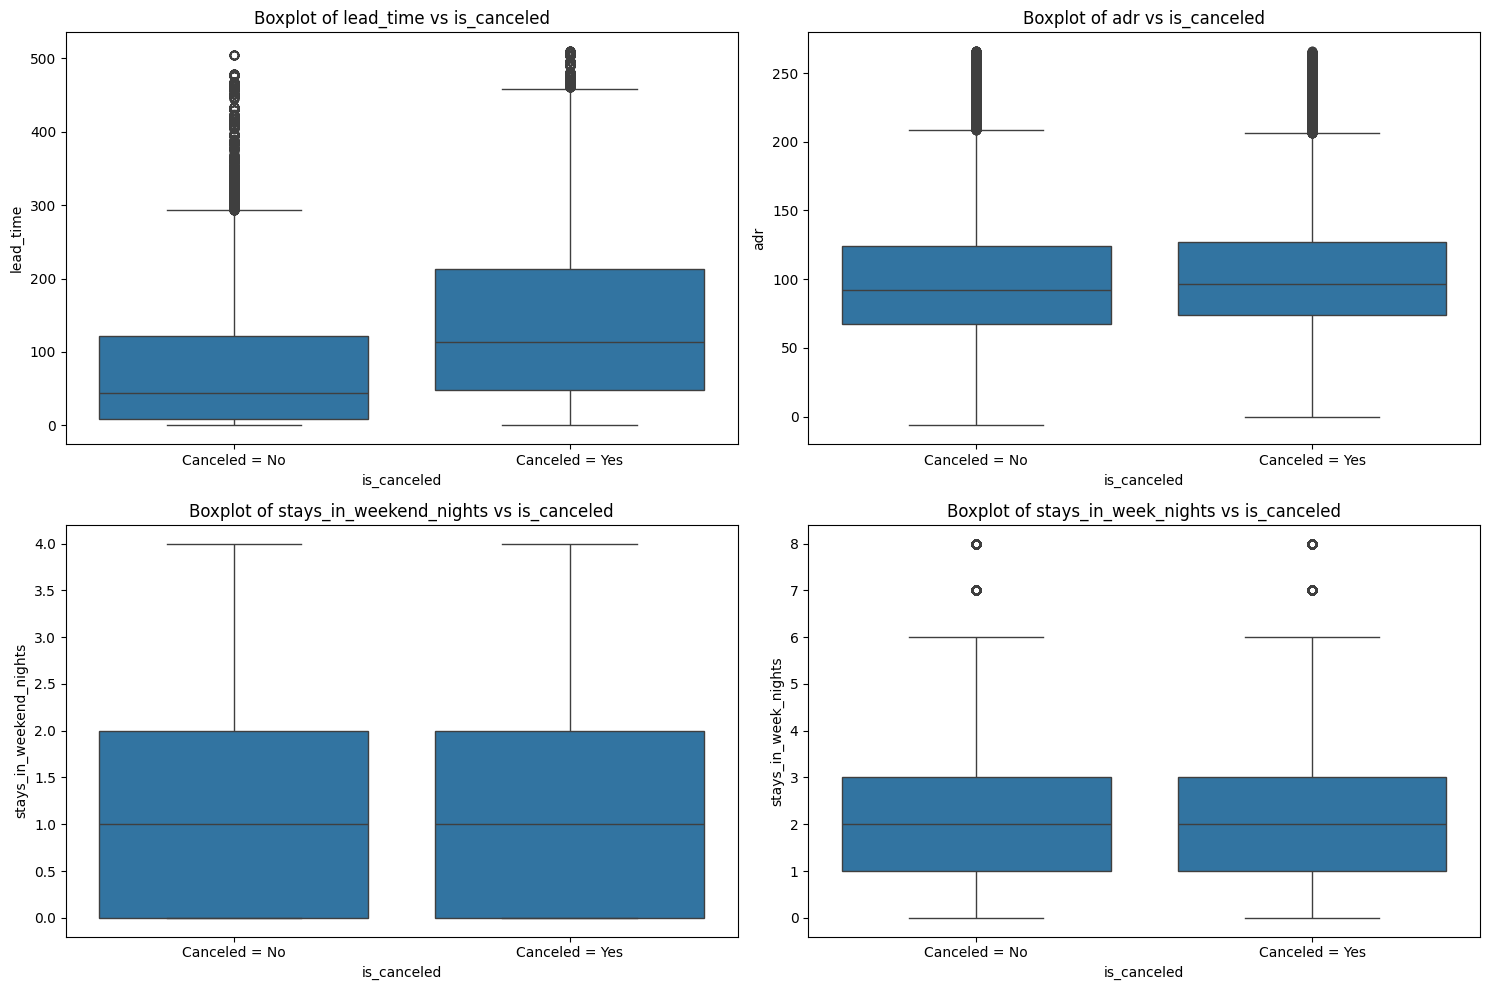

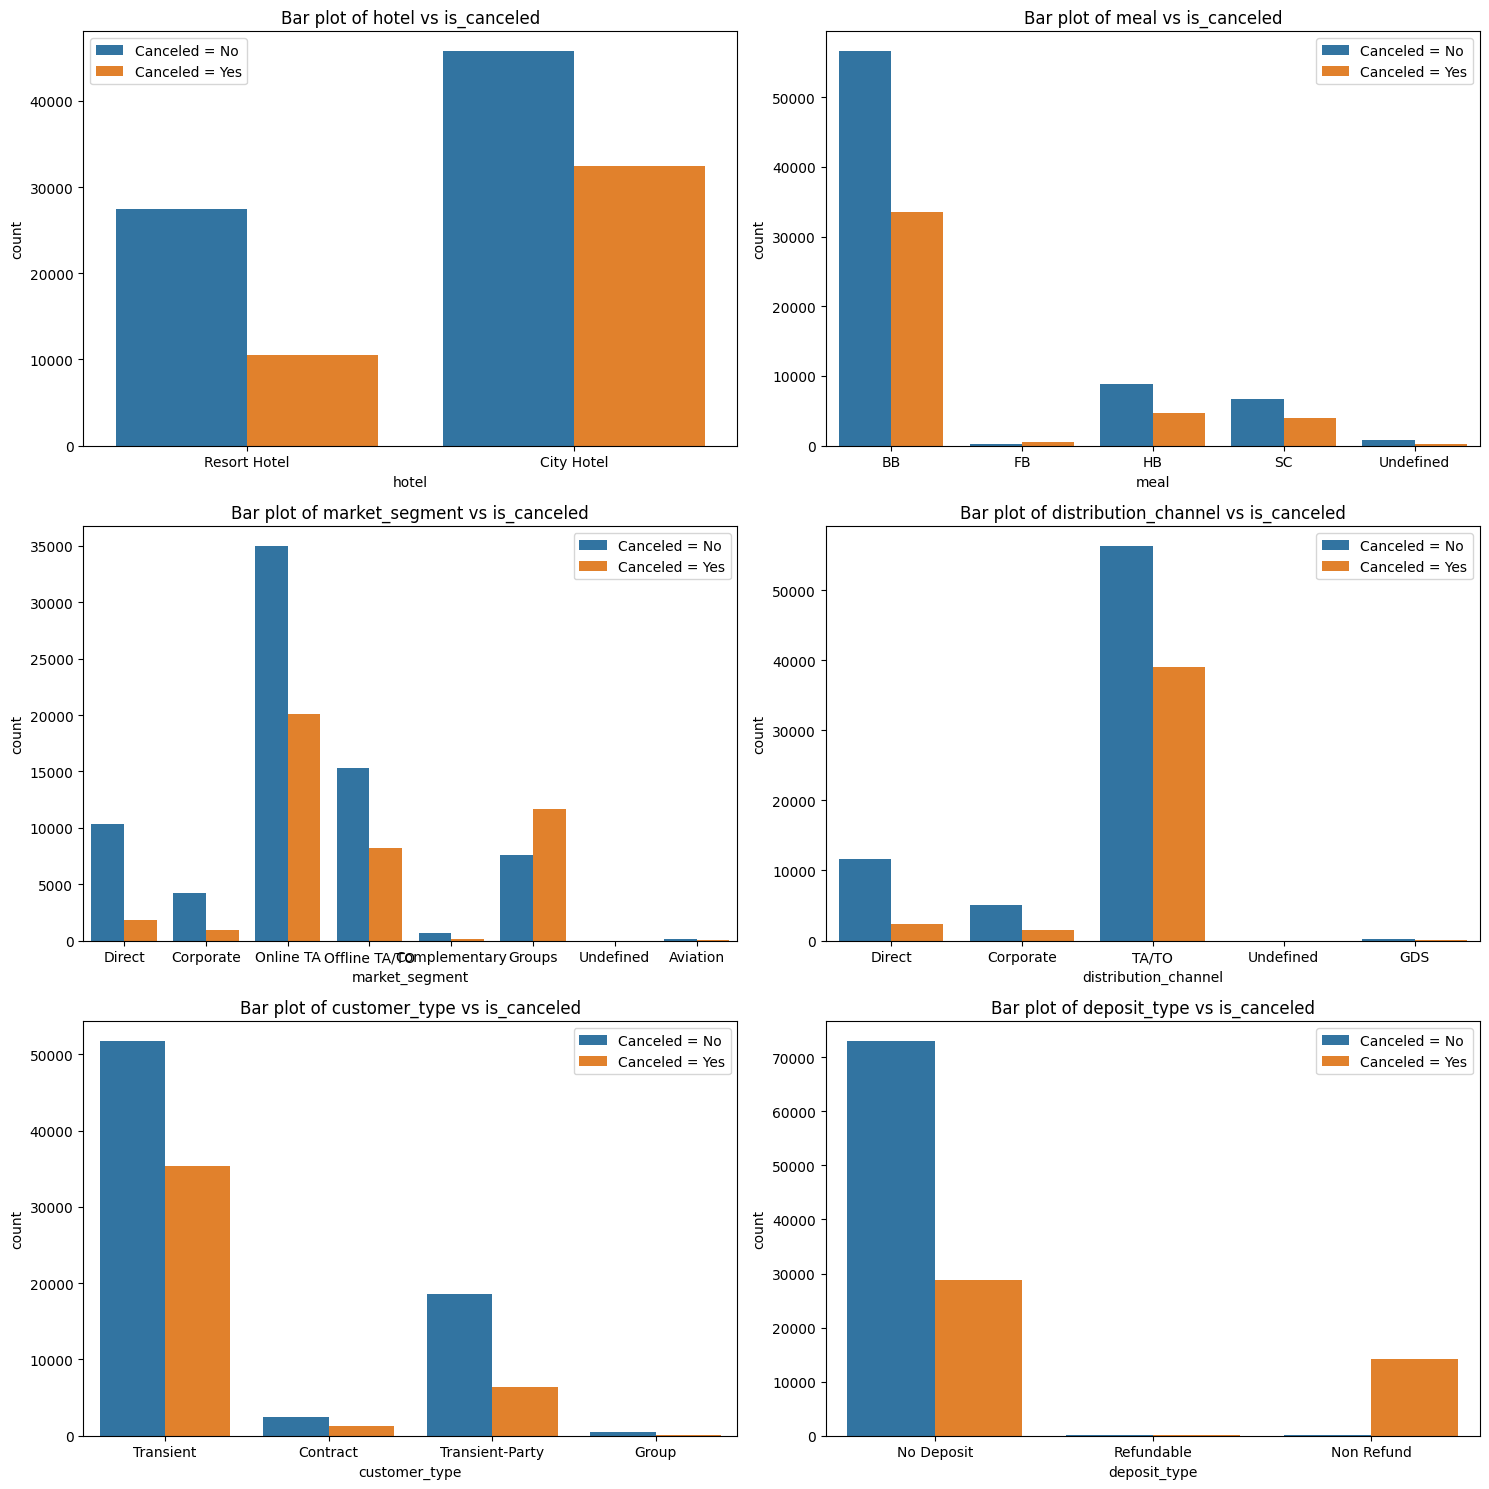

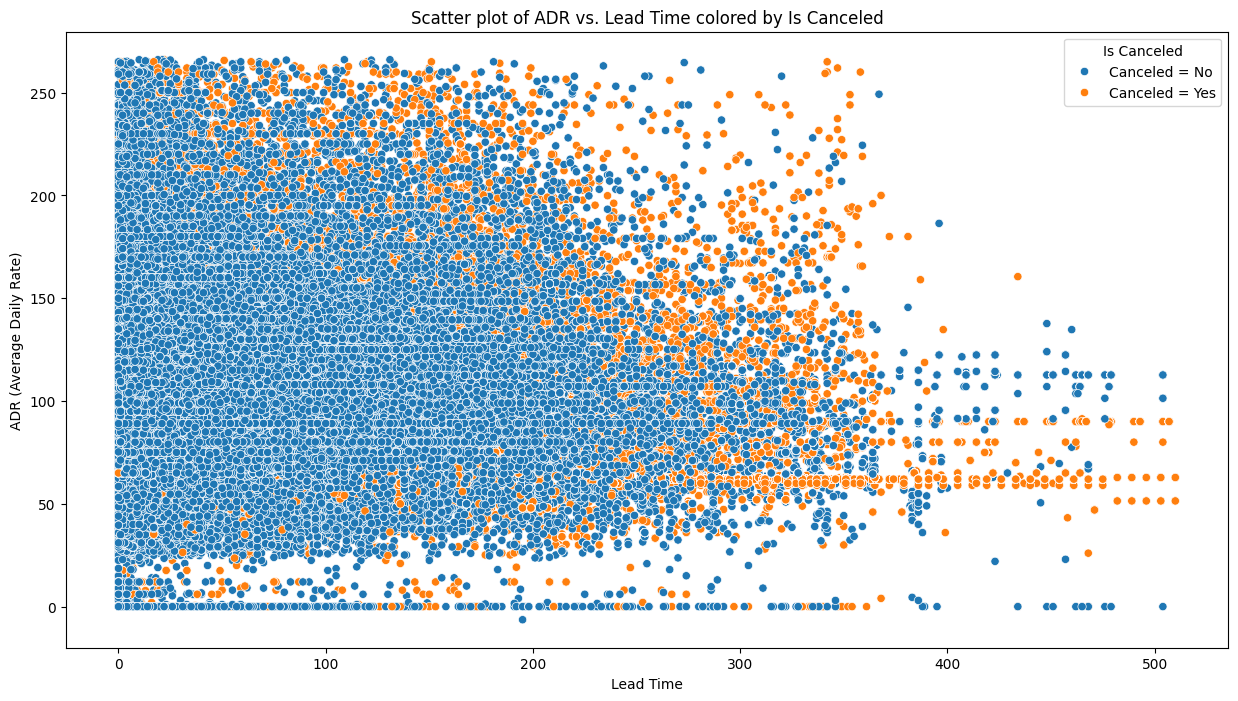

In [15]:
# List of numerical features to plot
numerical_features = ['lead_time', 'adr', 'stays_in_weekend_nights', 'stays_in_week_nights']

# Create a 2x2 matrix of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot box plots for each numerical feature against 'is_canceled'
for i, feature in enumerate(numerical_features):
    row = i // 2
    col = i % 2
    sns.boxplot(x='is_canceled', y=feature, data=df, ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {feature} vs is_canceled')
    axes[row, col].set_xticklabels(['Canceled = No', 'Canceled = Yes'])

plt.tight_layout()
plt.show()

# List of categorical features to plot
categorical_features = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'customer_type', 'deposit_type']

# Create a 3x2 matrix of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot bar plots for each categorical feature against 'is_canceled'
for i, feature in enumerate(categorical_features):
    row = i // 2
    col = i % 2
    sns.countplot(x=feature, hue='is_canceled', data=df, ax=axes[row, col])
    axes[row, col].set_title(f'Bar plot of {feature} vs is_canceled')
    handles, labels = axes[row, col].get_legend_handles_labels()
    axes[row, col].legend(handles, ['Canceled = No', 'Canceled = Yes'])

plt.tight_layout()
plt.show()

# Scatter plot of adr vs. lead_time colored by is_canceled
plt.figure(figsize=(15, 8))
sns.scatterplot(x='lead_time', y='adr', hue='is_canceled', data=df)
plt.title('Scatter plot of ADR vs. Lead Time colored by Is Canceled')
plt.xlabel('Lead Time')
plt.ylabel('ADR (Average Daily Rate)')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Canceled = No', 'Canceled = Yes'], title='Is Canceled')
plt.show()

The above plots give insight into both the strength and nature of the relationships between the chosen variables and booking cancellations, which will be helpful for feature selection and model interpretation in this project.

After analyzing the boxplots above, there are some conclusions to take into account:
- <b>lead_time vs is_canceled:</b> bookings with a longer lead_time are more likely to be cancelled, which suggests that people who booko in advance are more likely to change their plans.
- <b>adr vs is_canceled:</b> there is not a strong correlation between this two variables, suggesting that adr alone does not influence whether a book is canceled or not.
- <b>stays_in_weekend_nights vs is_canceled:</b> the number of weekend nights does not impact cancellation. People who book shorter or longer weekend stays seem equally likely to cancel.
- <b>stays_in_week_nights vs is_canceled:</b> this results are similar to stays_in_weekend_nights, therefore does not impact cancellation.

The analysis of the barplots leads to some concluions:
- <b>hotel vs is_canceled:</b> bookings at city hotels are more likely to be canceled than resort hotel bookings.
- <b>meal vs is_canceled:</b> the BB meal plan is the most common choice and has significant number of both cancellations and non-cancellations, therefore is the dominant option across the other categories (BF, HB, and SC)
- <b>market_segment vs is_canceled:</b> Online TA bookings have a high cancellation rate comparing with the others, which suggests that people who book through online travel agents are more likely to cancel. Direct and Corportate tend to have more stable bookings, with fewer cancellations.
- <b>distribution_channel vs is_canceled:</b> TA/TO channel has higher cancellation rates comparing with other distribution channels, suggesting that travel agents or tour operators bookings are less stable.
- <b>customer_type vs is_canceled:</b> transient customers have a higher likelihood of cancellation compared to the other customers types. On the other hand, transient-party shows some level of cancellations but not as higher than transient.
- <b>no_deposit vs is_canceled:</b> no deposit booking are more likely to cancel, indicating that when customers are not financially commited , they may feel free to cancel the reservation. The lower rate of cancellations of non-refund booking suggest that financial commitment reduces the likelihood of cancellation.

Finally, the analysis of scatterplot relating adr vs lead time and is_canceled shows that:
- lead time is a strong indicator of cancellation. Long lead times suggests that booking were made far in advance, therefore customers may have a higher chance of canceling they're bookings.
- adr alone does not have a strong correlation with cancellations,but combined with lead time at high values shows a slighly increase tendency for cancellations. We can observe that are some cancellations at high adr values

## Data Scaling

Is a preprocessing step used to standardize or normalize the range of independent variables (features) in a dataset. 

Scaling ensures that all features contribute equally to the model, improving its performance and stability.

In [16]:
# Normalize features to have the same scale
scaler = scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)

## Data Division

`Holdout Method` was applyed in order for the data to be randomly divided into two subsets: a training set and a test set. 

`Cross-validation` was used to assess the best ratio for holdout method and 80/20 turned out to bem the best ratio.

In [17]:
# Define the target variable and features
X = df_scaled.drop('is_canceled', axis=1)
y = df_encoded['is_canceled']

# Define a range of test sizes to evaluate
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]

# Initialize a dictionary to store the mean cross-validation scores for each test size
cv_scores = {}

# Evaluate each test size using cross-validation
# Ensure the target variable 'y' is of integer type
#y = y.astype(int)

for test_size in test_sizes:
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Initialize the model
    model = LogisticRegression(max_iter=1000)
    
    # Perform cross-validation and store the mean score
    scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_scores[test_size] = scores.mean()

# Find the best test size with the highest mean cross-validation score
best_test_size = max(cv_scores, key=cv_scores.get)
print(f"Best test size: {best_test_size}")

# Split the dataset using the best test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_test_size, random_state=42)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Best test size: 0.2
Training set shape: (92943, 24) (92943,)
Testing set shape: (23236, 24) (23236,)


## Data Balancing

This consists of a preprocessing step used when working with imbalanced datasets, where one class significantly outnumbers the others. 

This imbalance can lead to biased machine learning models that perform well for the majority class but poorly for the minority class.

Data Balancing improves model performance, provides better metrics, and mitigates bias.

To deal with imbalanced data in this data set we chose the combined method `SMOTETomek` method, a method that combines oversampling and undersampling for a balanced the dataset.

In [18]:
# Initialize the SMOTETomek object
smote_tomek = SMOTETomek(random_state=42, n_jobs = -1)

# Apply SMOTETomek to the training data
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Display the class distribution before and after resampling
print("Before resampling:", Counter(y_train))
print("After resampling:", Counter(y_resampled))

display(X_resampled.head())
display(y_resampled.head())

Before resampling: Counter({0: 58763, 1: 34180})
After resampling: Counter({0: 57475, 1: 57475})


,hotel,lead_time,arrival_date_month,stays_in_weekend_nights,adults,babies,meal,country,market_segment,distribution_channel,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date_year,reservation_status_date_month,reservation_status_date_day
0,1.434456,0.608886,1.762809,-0.978801,-1.468384,-0.08055,3.228962,0.929220,-0.734253,0.455959,...,-0.342835,-0.372971,6.712105,1.499490,-2.216062,-0.253633,-0.728736,-0.128017,-1.583807,-1.440486
1,-0.697128,0.241773,1.116292,-0.978801,0.252282,-0.08055,-0.515814,-1.738262,0.844325,0.455959,...,-0.342835,-0.372971,-0.133582,-0.254671,0.696649,-0.253633,1.877990,-0.128017,0.800802,-1.098794
2,-0.697128,-0.946511,1.439550,-0.978801,-1.468384,-0.08055,-0.515814,0.929220,-2.312830,-2.846523,...,-0.342835,-0.372971,-0.133582,-0.254671,-0.785025,-0.253633,0.574627,-0.128017,1.396955,-1.326588
3,-0.697128,1.217519,1.116292,-0.978801,0.252282,-0.08055,-0.515814,-1.110619,0.844325,0.455959,...,-0.342835,-0.372971,-0.133582,1.499490,0.048279,-0.253633,0.574627,-0.128017,1.098879,-0.757102
4,-0.697128,1.932421,-0.500000,-0.978801,0.252282,-0.08055,-0.515814,0.929220,-0.734253,0.455959,...,-0.342835,2.616020,-0.133582,-0.254671,-0.851073,-0.253633,-0.728736,-1.528743,1.098879,0.609664


0    0
1    1
2    0
3    0
4    1
Name: is_canceled, dtype: int64

Before resampling we can observe that the initial class is imbalance and after resampling we can see that the classes are now balanced, with equal representation in the dataset.

SMOTETomek method helped balancing the dataset as we can see from the results above.
- SMOTE has added synthetic samples to the minority class (1) to match the majority class count (57475 samples each).
- Tomek Links removed some ambiguous samples from the majority class.


## Lasso Regularization

It’s a type of linear regression that incorporates L1 regularization to prevent overfitting and enhance model interpretability and is a useful tool for regularization and feature selection.

Lasso Regularization adds a penalty term to the linear regression cost function based on the absolute values of the coefficients of the features. This penalty term helps in both:
- reducing the size of coefficients (shrinkage).
- forcing some coefficients to become exactly zero, which effectively removes those features from the model.

By doing this, Lasso Regularization improves model simplicity by retaining only the most relevant features.

In [19]:
# Method: Lasso Regularization
def lasso_regularization(X, y):
    scaler = StandardScaler()
    scaler.fit(X)
    
    # Fit a Lasso model with cross-validation
    lasso = LassoCV(cv=5).fit(X, y)
    
    # Select features with non-zero coefficients
    sel_ = SelectFromModel(lasso, prefit=True).fit(X, y)

    # make a list with the selected features
    selected_feat = X.columns[(sel_.get_support())]
    
    print("Number of features which coefficient was shrank to zero: ", np.sum(lasso.coef_ == 0))
    removed_feats = X.columns[(lasso.coef_ == 0).ravel().tolist()]
    print("Removed features: ", removed_feats)
    
    # Transform the data
    X_lasso = pd.DataFrame(sel_.transform(X), columns=selected_feat)
    
    return removed_feats, X_lasso

# Use Lasso Regularization to select features
removed_feats, lasso_results = lasso_regularization(X_resampled, y_resampled)
# Remove features with zero coefficients if they exist
if removed_feats.size > 0:
    X_resampled.drop(removed_feats, axis=1, inplace=True)
    X_test.drop(removed_feats, axis=1, inplace=True)

Number of features which coefficient was shrank to zero:  0
Removed features:  Index([], dtype='object')


As a result we can see that Lasso Regularization did not shrink any of the feature coefficients to zero, and we can infer that all features were deemed relevant for predicting the target variable. This could happen if the features have strong correlations with the target or if all features provide unique information without much redundancy.

In this case, the cross-validation chosen by LassoCV might have selected a small alpha, indicating that minimal regularization is optimal for this data, therefore the penalty applied to the coefficients is weaker and this may prevent coefficients from being reduced to zero.

In conclusion, output suggests that all features contribute meaningfully to the model, which a good sign, as it indicates a well-designed feature set.

## Model Creation and Training

<b>`Model Creation:`</b> is a process of selecting and initializing a model based on the problem type, data characteristics and specific goals, and that will be used to learn from data.

We will try to find the best parameters for each model using the following models:
- <b>Logistic Regression:</b> is a statistical model used for binary classification problems. It predicts the probability that a given input belongs to a certain class. It is a linear model for classification rather than regression.
- <b>Decision Tree:</b> used for both classification and regression tasks. They work by splitting the data into subsets based on the value of input features, creating a tree-like model of decisions.
- <b>Random Forest:</b> is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees. It improves accuracy and controls overfitting by averaging the results of multiple trees.
- <b>Gradient Boosting:</b> used to builds models sequentially, each correcting the errors of the previous one.
- <b>K-Nearest Neighbors:</b> used for classification and regression. It works by finding the ‘k’ training samples closest in distance to a new sample and predicting the label based on the majority class (for classification) or average (for regression) of these neighbors.
- <b>Naive Bayes:</b> is a probabilistic classifiers based on applying Bayes’ theorem with strong (naive) independence assumptions between the features.
- <b>Bagging Classifier:</b> is an ensemble method that helps improve the performance of weak models by reducing variance and improving robustness. This method trains multiple models independently on random subsets of the data and then aggregates their predictions.
- <b>XGBoost:</b> is an advanced gradient boosting algorithm that offers high speed and performance, with regularization options to prevent overfitting.
- <b>AdaBoost:</b> it is used for classification and regression tasks, and improves model performance by focusing on misclassified instances from previous models in a sequential way.
- <b>LightGBM:</b> is an advanced gradient boosting algorithm that is designed for efficiency.
- <b>Neural Network:</b> moodeled loosely after the human brain, it is designed to recognize patterns. They interpret sensory data through a kind of machine perception, labeling, or clustering of raw input.

<b>`Model Training:`</b> is the process of feeding data to the model so it can learn patterns and relationships. Training the model will minimize errors and generalize well new, unseen data.

### Finding best parameters for each model through Gridsearch

GridSearchCV helps finding the best parameters for various machine learning models, tunning them for better performance and results. It defines a set of parameter grids for each model, initializes the models, and then iterates through each model to perform grid search. The grid search optimizes the model’s hyperparameters based on cross-validated and accuracy scores. If a model has parameters to tune, GridSearchCV is used to find the best combination of parameters. If not, the model is simply trained on the provided data. The best models with their optimal parameters are stored for further use, eliminating the need to repeat this process which is costly in time and processing power. Running it once allowed for the optimized parameters for each model to be stored and will always be used thereafter.

In [ ]:
# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'Naive Bayes': {},
    'Bagging Classifier': {
        'n_estimators': [10, 50, 100]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200], 
        'learning_rate': [0.01, 0.1, 1]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd']
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
#    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB(),
    'Bagging Classifier': BaggingClassifier(),
    'XGBoost': XGBClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'LightGBM': LGBMClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000)
}

# Perform Grid Search for each model
best_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    if param_grids[name]:  # Check if there are parameters to tune
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_resampled, y_resampled)
        best_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:
        model.fit(X_resampled, y_resampled)
        best_models[name] = model

Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Training Decision Tree...
Best parameters for Decision Tree: {'max_depth': 30, 'min_samples_split': 2}
Training Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Training Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Training K-Nearest Neighbors...
Best parameters for K-Nearest Neighbors: {'n_neighbors': 3, 'weights': 'distance'}
Training Naive Bayes...
Training Bagging Classifier...
Best parameters for Bagging Classifier: {'n_estimators': 100}
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Training AdaBoost...
Best parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 200}
Training LightGBM...
[LightGBM] [Info] Number of positive: 57475, number of negative: 57475
[LightGBM]

### Training models with the best parameters

In [20]:
# Initialize models with the best parameters
best_models = {
    'Logistic Regression': LogisticRegression(C=10, max_iter=1000, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=200),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=200),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3, weights='distance'),
    'Naive Bayes': GaussianNB(),
    'Bagging Classifier': BaggingClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(n_estimators=200, learning_rate=0.2, max_depth=7),
    'AdaBoost': AdaBoostClassifier(learning_rate=1, n_estimators=200),
    'LightGBM': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=200),
    'Neural Network': MLPClassifier(activation='relu', hidden_layer_sizes=(50, 50), solver='adam', max_iter=1000)
}

# Train each model with the best parameters
for name, model in best_models.items():
    print(f"Training {name}...")
    model.fit(X_resampled, y_resampled)
    print(f"{name} trained successfully.")

Training Logistic Regression...
Logistic Regression trained successfully.
Training Decision Tree...
Decision Tree trained successfully.
Training Random Forest...
Random Forest trained successfully.
Training Gradient Boosting...
Gradient Boosting trained successfully.
Training K-Nearest Neighbors...
K-Nearest Neighbors trained successfully.
Training Naive Bayes...
Naive Bayes trained successfully.
Training Bagging Classifier...
Bagging Classifier trained successfully.
Training XGBoost...
XGBoost trained successfully.
Training AdaBoost...
AdaBoost trained successfully.
Training LightGBM...
[LightGBM] [Info] Number of positive: 57475, number of negative: 57475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3983
[LightGBM] [Info] Number of data points in the train set: 114950, number o

## Model Evaluation

- Is the process of assessing how well a trained machine learning model performs on a given dataset, typically a test or validation set. It involves using specific metrics and techniques to measure the accuracy, reliability, and generalization ability of the model. 
- Helps you understand whether a model meets the requirements for accuracy and performance and provides insights for further tuning or selection among different models.

This step is important to:
- ensure the model’s predictions align with reality or ground truth data.
- test if a model trained on one dataset can make reliable predictions on unseen data.
- help select the best model.
- highlight specific areas where the model may underperform, like bias towards certain classes or poor handling of rare events.

The following list contains the classification evaluation metrics used:
- <b>Confusion Matrix:</b> displays true positives, false positives, true negatives, and false negatives.It helps to see the distribution of predictions across actual classes.
- <b>Accuracy:</b> the ratio of correctly predicted instances to the total instances. High accuracy suggests that the model correctly classifies most samples.
- <b>Precision:</b> measures the proportion of true positive predictions out of all positive predictions (useful for reducing false positives). High precision means the model makes fewer false-positive errors.
- <b>Recall:</b> measures the proportion of true positives out of actual positives (useful for reducing false negatives). High recall means the model misses fewer positives.
- <b>F1 Score:</b> the harmonic mean of precision and recall, balancing both metrics. Useful when you want a single measure that accounts for both false positives and false negatives.
- <b>ROC AUC (Receiver Operating Characteristic - Area Under Curve):</b> ROC curves show the trade-off between true positive and false positive rates. AUC is a single value summarizing the curve. It’s helpful for binary classification and understanding model separability. The closer to 1, the better, with values closer to 0.5 indicating random guessing.


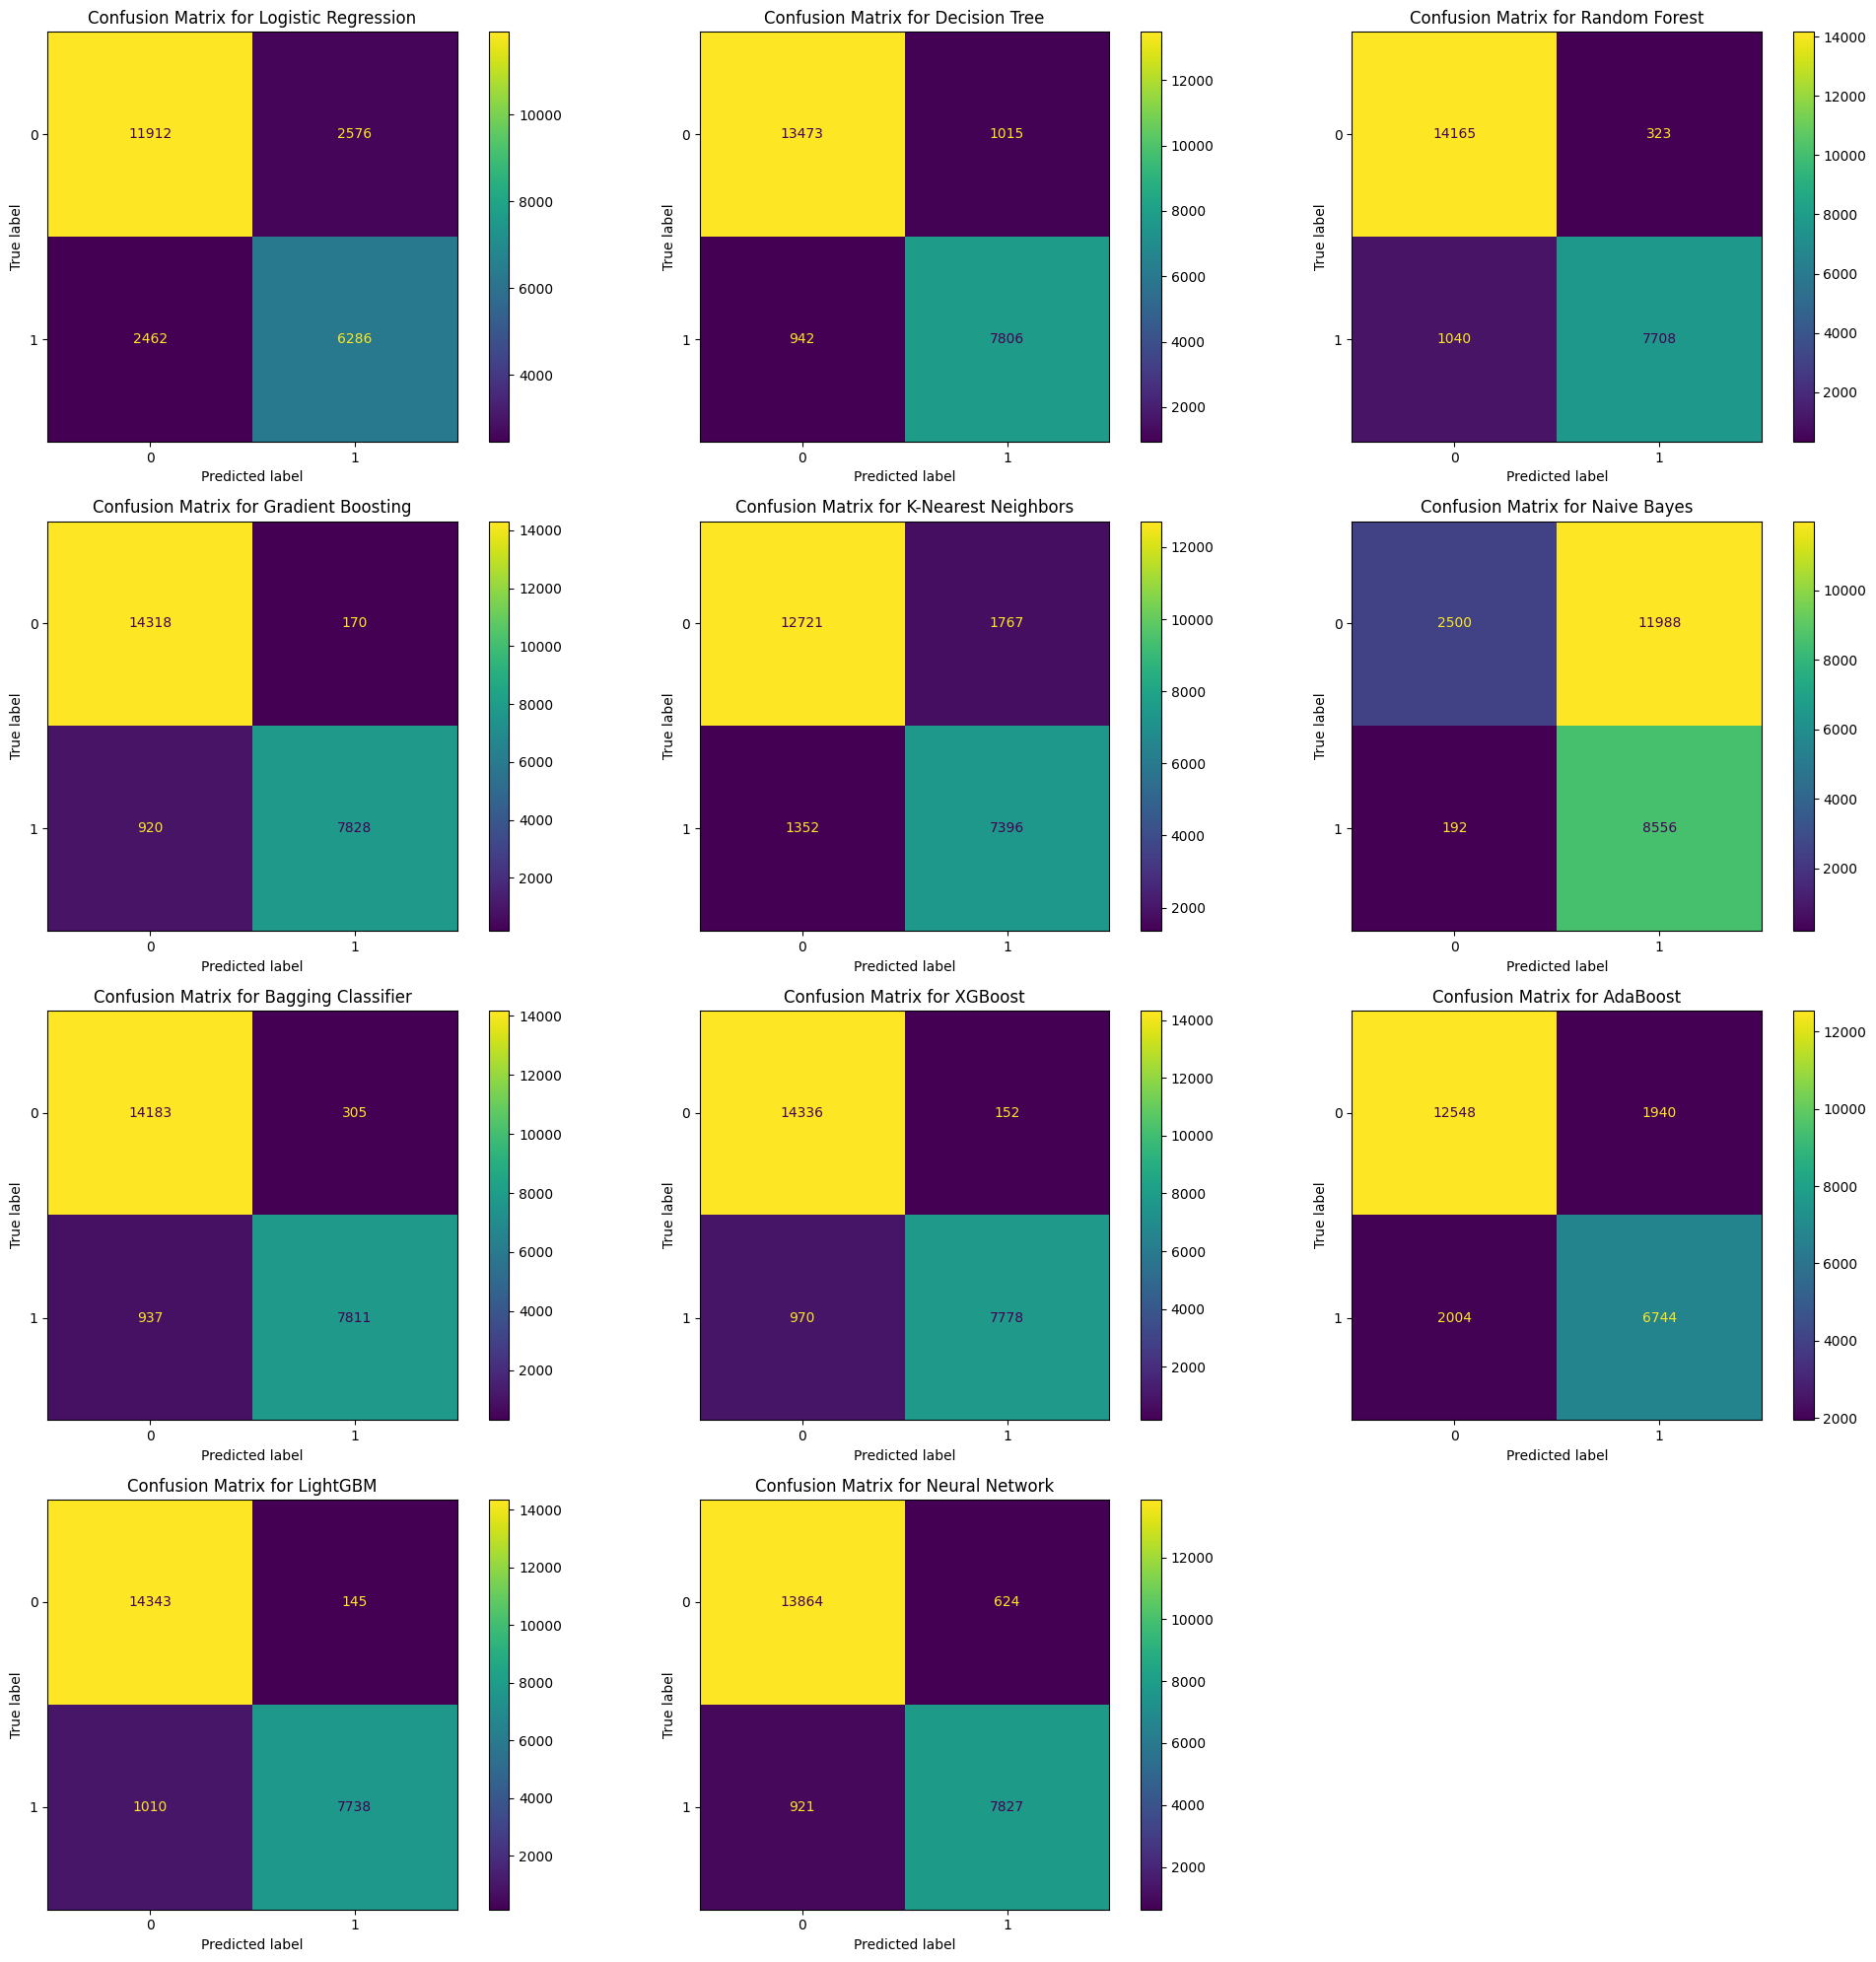

In [21]:
# Evaluate models and store results
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred) * 100,
        'Precision': precision_score(y_test, y_pred) * 100,
        'Recall': recall_score(y_test, y_pred) * 100,
        'F1 Score': f1_score(y_test, y_pred) * 100,
        'ROC AUC': roc_auc_score(y_test, y_proba) * 100 if y_proba is not None else None,
    }

# Display and print confusion matrices for each model in a 4x3 matrix
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

for i, (name, model) in enumerate(best_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    # print(f"Confusion Matrix for {name}:")
    # print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    row = i // 3
    col = i % 3
    disp.plot(ax=axes[row, col], cmap='viridis')
    axes[row, col].set_title(f"Confusion Matrix for {name}")

# Remove any empty subplots
for j in range(i + 1, 12):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,78.32%,70.93%,71.86%,71.39%,85.70%
Decision Tree,91.58%,88.49%,89.23%,88.86%,91.11%
Random Forest,94.13%,95.98%,88.11%,91.88%,98.06%
Gradient Boosting,95.31%,97.87%,89.48%,93.49%,98.48%
K-Nearest Neighbors,86.58%,80.72%,84.55%,82.59%,91.00%
Naive Bayes,47.58%,41.65%,97.81%,58.42%,80.35%
Bagging Classifier,94.65%,96.24%,89.29%,92.64%,98.06%
XGBoost,95.17%,98.08%,88.91%,93.27%,98.49%
AdaBoost,83.03%,77.66%,77.09%,77.37%,90.92%
LightGBM,95.03%,98.16%,88.45%,93.06%,98.36%


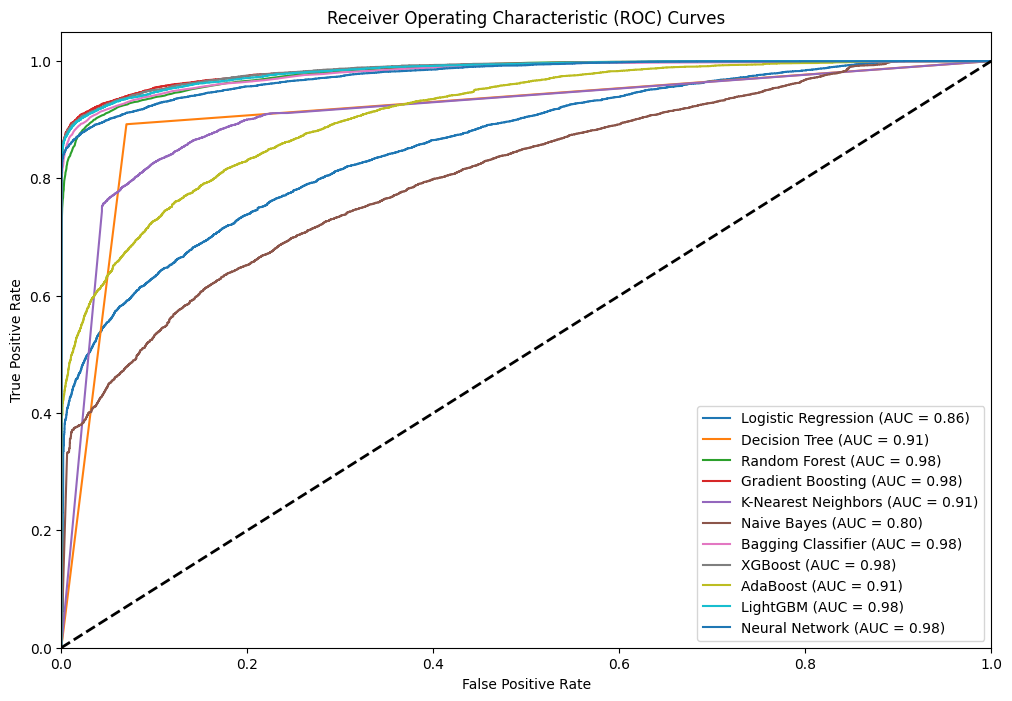

In [22]:
# Display results in a DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.applymap(lambda x: f"{x:.2f}%" if pd.notnull(x) else x)
display(results_df)

# Plot ROC AUC curves for each model
plt.figure(figsize=(12, 8))

for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

The values obtained in each confusion matrix were used to calculate important metrics to evaluate the model's performance. 

- <b>Logistic Regression</b>
    - True Negatives = 11912 instances were correctly identified
    - False Negatives = 2462. The model incorrectly identified 2462 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 2576. The model incorrectly classified 2576 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 6286 instances were correctly identified
    - Both Accuracy(78.32%) and F1 Score (70.93%) are relatively low, indicating lower predictive power, suggesting that Logistic Regression is underfitting. On the other hand, ROC-AUC (85.70%) is fairly high, which suggests it does a reasonable job separating classes but may not handle all classes effectively.

- <b>Decision Tree</b>
    - True Negatives = 13481 instances were correctly identified
    - False Negatives = 952. The model incorrectly identified 952 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 1007. The model incorrectly classified 1007 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 7796 instances were correctly identified
    - Accuracy (91.58%) and F1 Score (88.86%) are high, meaning a good overall performance, but Precision (88.49%) is a bit lower than other ensemble methods. Decision Tree models can perform well with this dataset, but they are likely to overfit.

- <b>Random Forest</b>
    - True Negatives = 14146 instances were correctly identified
    - False Negatives = 1061. The model incorrectly identified 1061 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 342. The model incorrectly classified 342 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 7687 instances were correctly identified
    - Accuracy (94.13%) and ROC AUC (98.06%) shows high values, indicating it separates classes well. Precision (95.98%) as a high value as well, but Recall (88.11%) is lower, which indicates it may prioritize fewer false positives over capturing all positives. This model performs well, particularly when balanced between Precision and F1 Score.

- <b>Gradient Boosting</b>
    - True Negatives = 14317 instances were correctly identified
    - False Negatives = 919. The model incorrectly identified 1061 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 171. The model incorrectly classified 342 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 7829 instances were correctly identified
    - This model has the highest Accuracy (95.31%) and ROC AUC (98.48%) values, as well as Precision (97.87%). Recall (89.48%) as a lower value. This model has excellent generalization with minimal overfitting, balancing high precision with slightly lower recall.

- <b>K-Nearest Neighbor</b>
    - True Negatives = 12721 instances were correctly identified
    - False Negatives = 1352. The model incorrectly identified 1352 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 1767. The model incorrectly classified 1767 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 7396 instances were correctly identified
    - Accuracy (86.58%) and F1 Score (82.59%) have lower values. The Recall (84.55%) value is slightly high, which suggest it captures most positives but might also include some false negatives. This model isn't as good as boosting or bagging methods.

- <b>Naive Bayes</b>
    - True Negatives = 2500 instances were correctly identified
    - False Negatives = 192. The model incorrectly identified 192 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 11988. The model incorrectly classified 11988 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 8556 instances were correctly identified
    - Both Accuracy (47.58%) and F1 Score (58.42%) are very low, which indicates a poor performance. Although it presents a high Recall (97.81%) value it has a low Precision (41.65%), indicating overpredicts positives. This model struggles with the evaluation of this dataset.

- <b>Bagging Classifier</b>
    - True Negatives = 14198 instances were correctly identified
    - False Negatives = 932. The model incorrectly identified 932 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 290. The model incorrectly classified 290 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 7816 instances were correctly identified
    - high values of Accuracy (94.65%) and ROC AUC (98.06%) shows good separation and reliability. High values of Precision (96.24%) and F1 Score (92.64%) means that it is well balanced, which indicates a few errors. Based on the results, this models is highly effective, combining Accuracy and Precision, with good generalization.

- <b>XGBoost</b>
    - True Negatives = 14336 instances were correctly identified
    - False Negatives = 970. The model incorrectly identified 970 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 152. The model incorrectly classified 152 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 7778 instances were correctly identified
    - The values of Accuracy (95.17%), ROC AUC (98.49%) and Precision (98.08%) are very high, but the Recall (88.91%) value is a bit lower in comparison. This model performs well with high precision, though it may slightly unde4r-recall positives.

- <b>AdaBoost</b>
    - True Negatives = 12548 instances were correctly identified
    - False Negatives = 2004. The model incorrectly identified 2004 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 1940. The model incorrectly classified 1940 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 6744 instances were correctly identified
    -  This model presents moderate Accuracy (83.03%) and F1 Score (77.37%) values, suggesting that it is somewhat effective but not as strong as Gradient Boost.

- <b>LightGBM</b>
    - True Negatives = 14343 instances were correctly identified
    - False Negatives = 1010. The model incorrectly identified 1010 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 145. The model incorrectly classified 145 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 7738 instances were correctly identified
    - The high values of Accuracy (95.03%) and ROC AUC (98.36%) indicates good performance. Precision (98.16%) presents an extremely high value too. This model, like XGBoost, provides high precision.

- <b>Neural Network</b>
    - True Negatives = 13910 instances were correctly identified
    - False Negatives = 955. The model incorrectly identified 955 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 578. The model incorrectly classified 578 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 7793 instances were correctly identified
    - Even though this model presents high values of Accuracy (93.35%), ROC AUC (97.68%), and Precision (92.62%), showing a strong performance, comparing to other models, such as Gradient Boosting or XGBoost, the perfomance is quite lower.


In conclusion we can infer that:
- Gradient Boosting, XGBoost, LightGBM, and Bagging Classifier are the best performing models with high Accuracy, ROC AUC, and F1 Scores. 
- XGBoost and LightGBM emphasize high Precision but slightly lower Recall, indicating they minimize false positives but might miss some positives.
- Gradient Boosting provides high accuracy with a good balance between precision and recall, making them suitable if recall is important.
- Logistic Regression and Naive Bayes show significantly lower accuracy and F1 Scores, indicating they may not capture the complexities in the data well.

<b>XGBoost or LightGBM are the best choices if we want to minimize false positives (high precision), while Gradient Boosting would be the best choices for balanced overall performance with fewer errors.</b>

## Method Combination (Ensemble)

Ensemble methods are techniques that combine predictions from multiple models to improve overall performance, accuracy, and robustness. Rather than relying on a single model, ensemble methods leverage the strengths of multiple models, which can help to reduce the risk of overfitting, lower bias, and reduce variance. Ensemble methods are highly effective in both classification and regression tasks and are used widely in machine learning competitions and real-world applications.

### Stacking Ensemble

- The base models were chosen to provide diversity in learning different types of patterns (linear, non-linear, complex interactions).
- Logistic Regression was chosen as the meta-model to balance simplicity and effectiveness, helping to combine the strengths of each base model without overfitting.

In [23]:
# Define base models
base_estimators = [
    ('gradient_boosting', best_models['Gradient Boosting']),
    ('xgboost', best_models['XGBoost']),
    ('random_forest', best_models['Random Forest']),
    ('logistic_regression', best_models['Logistic Regression']),
    ('neural_network', best_models['Neural Network'])
]

# Define the meta-model
meta_model = LogisticRegression()

# Stacking ensemble
stacking_ensemble = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=5
)

# Train the stacking ensemble
stacking_ensemble.fit(X_resampled, y_resampled)

# Predict with the stacking ensemble
stacking_predictions = stacking_ensemble.predict(X_test)

### Voting Ensemble (Soft)

Uses weighted probabilities to make predictions, with weights tailored based on each model’s performance. A mix of boosting models, bagging, linear and neural network were chosen to try and leverage the strengths of each model type, with boosting models given more influence due to their previously demonstrated better performance.

In [ ]:
# Define models with individual weights (higher weight for better models)
voting_ensemble = VotingClassifier(
    estimators=[
        ('gradient_boosting', best_models['Gradient Boosting']),
        ('xgboost', best_models['XGBoost']),
        ('lightgbm', best_models['LightGBM']),
        ('random_forest', best_models['Random Forest']),
        ('logistic_regression', best_models['Logistic Regression']),
        ('neural_network', best_models['Neural Network'])
    ],
    voting='soft',  # 'soft' voting for probability-based voting
    weights=[1, 2, 2, 1, 1, 1]  # weights based on model performance (higher for better models)
)

# Train the voting ensemble
voting_ensemble.fit(X_train, y_train)

# Predict with the voting ensemble
voting_predictions = voting_ensemble.predict(X_test)

[LightGBM] [Info] Number of positive: 34180, number of negative: 58763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 92943, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.367752 -> initscore=-0.541872
[LightGBM] [Info] Start training from score -0.541872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Blending Ensemble of Bagging and Boosting

The Blending Ensemble of Bagging and Boosting leverages the complementary strengths of each included model:

Bagging models (Random Forest, Bagging Classifier) provide stability and reduce variance while Boosting models (Gradient Boosting, XGBoost) improve accuracy by reducing bias and capturing complex patterns. This combination is likely to deliver a stronger, more balanced performance.

In [25]:
# Initialize models
models = {
    'random_forest': best_models['Random Forest'],  
    'bagging_classifier': best_models['Bagging Classifier'],
    'gradient_boosting': best_models['Gradient Boosting'],
    'xgboost': best_models['XGBoost'],
    'lightgbm': best_models['LightGBM']
}

# Fit each model on the training data
for name, model in models.items():
    model.fit(X_train, y_train)

# Generate predictions from each model and take a weighted average
predictions = np.zeros((X_test.shape[0], len(models)))
for i, (name, model) in enumerate(models.items()):
    predictions[:, i] = model.predict_proba(X_test)[:, 1]  # Assuming binary classification

# Average the predictions
blended_predictions = np.mean(predictions, axis=1)
final_predictions = (blended_predictions > 0.5).astype(int)  # Threshold at 0.5

[LightGBM] [Info] Number of positive: 34180, number of negative: 58763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 92943, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.367752 -> initscore=-0.541872
[LightGBM] [Info] Start training from score -0.541872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Method Combination (Ensemble) Evaluation

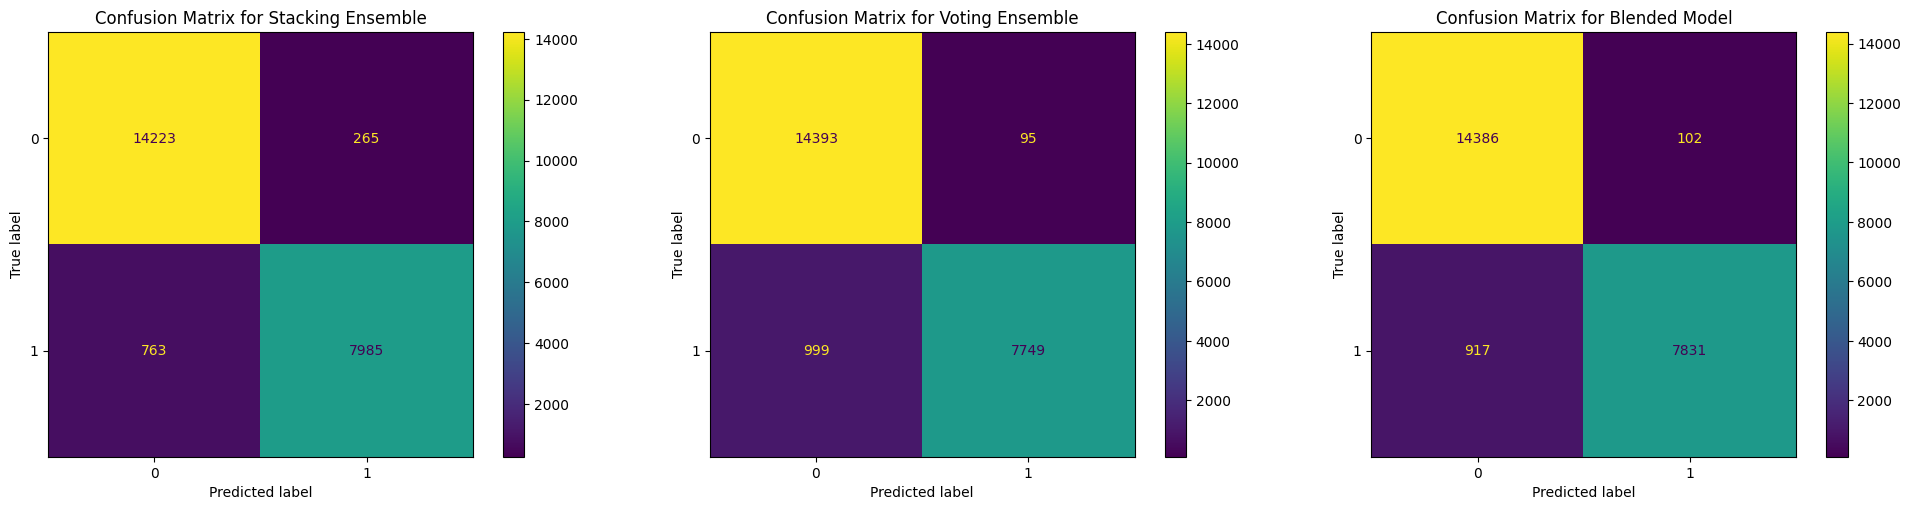

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Stacking Ensemble,95.58%,96.79%,91.28%,93.95%,98.59%
1,Voting Ensemble,95.29%,98.79%,88.58%,93.41%,98.66%
2,Blended Model,95.61%,98.71%,89.52%,93.89%,98.81%


In [26]:
# Evaluate the stacking ensemble model
stacking_accuracy = accuracy_score(y_test, stacking_predictions)
stacking_precision = precision_score(y_test, stacking_predictions)
stacking_recall = recall_score(y_test, stacking_predictions)
stacking_f1 = f1_score(y_test, stacking_predictions)
stacking_roc_auc = roc_auc_score(y_test, stacking_ensemble.predict_proba(X_test)[:, 1])

# Evaluate the voting ensemble model
voting_accuracy = accuracy_score(y_test, voting_predictions)
voting_precision = precision_score(y_test, voting_predictions)
voting_recall = recall_score(y_test, voting_predictions)
voting_f1 = f1_score(y_test, voting_predictions)
voting_roc_auc = roc_auc_score(y_test, voting_ensemble.predict_proba(X_test)[:, 1])

# Evaluate the blended model
blended_accuracy = accuracy_score(y_test, final_predictions)
blended_precision = precision_score(y_test, final_predictions)
blended_recall = recall_score(y_test, final_predictions)
blended_f1 = f1_score(y_test, final_predictions)
blended_roc_auc = roc_auc_score(y_test, blended_predictions)

# Create a DataFrame to display the results
ensemble_results = pd.DataFrame({
    'Model': ['Stacking Ensemble', 'Voting Ensemble', 'Blended Model'],
    'Accuracy': [stacking_accuracy, voting_accuracy, blended_accuracy],
    'Precision': [stacking_precision, voting_precision, blended_precision],
    'Recall': [stacking_recall, voting_recall, blended_recall],
    'F1 Score': [stacking_f1, voting_f1, blended_f1],
    'ROC AUC': [stacking_roc_auc, voting_roc_auc, blended_roc_auc]
})

# Generate predictions for each ensemble model
stacking_predictions = stacking_ensemble.predict(X_test)
voting_predictions = voting_ensemble.predict(X_test)
blended_predictions = (blended_predictions > 0.5).astype(int)

# Compute confusion matrices
cm_stacking = confusion_matrix(y_test, stacking_predictions)
cm_voting = confusion_matrix(y_test, voting_predictions)
cm_blended = confusion_matrix(y_test, blended_predictions)

# Plot confusion matrices in a 1x3 matrix
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Stacking Ensemble
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking)
disp_stacking.plot(ax=axes[0], cmap='viridis')
axes[0].set_title("Confusion Matrix for Stacking Ensemble")

# Voting Ensemble
disp_voting = ConfusionMatrixDisplay(confusion_matrix=cm_voting)
disp_voting.plot(ax=axes[1], cmap='viridis')
axes[1].set_title("Confusion Matrix for Voting Ensemble")

# Blended Model
disp_blended = ConfusionMatrixDisplay(confusion_matrix=cm_blended)
disp_blended.plot(ax=axes[2], cmap='viridis')
axes[2].set_title("Confusion Matrix for Blended Model")

plt.tight_layout()
plt.show()

# Convert the results to percentage format for better readability
ensemble_results[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']] = ensemble_results[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']].applymap(lambda x: f"{x*100:.2f}%")

# Display the results
display(ensemble_results)

The analysis of the method combination (ensemble) evaluation shows:
- <b>Stacking Ensemble</b>
    - True Negatives = 14223 instances were correctly identified
    - False Negatives = 763. The model incorrectly identified 763 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 265. The model incorrectly classified 265 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 7985 instances were correctly identified

-<b>Voting Ensemble</b>
    - True Negatives = 14393 instances were correctly identified
    - False Negatives = 999. The model incorrectly identified 999 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 95. The model incorrectly classified 95 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 7749 instances were correctly identified

- <b>Blended Model</b>
    - True Negatives = 436 instances were correctly identified
    - False Negatives = 917. The model incorrectly identified 917 positive instances as negative, suggesting that the model made a negative prediction, but the actual class was positive.
    - False Positives = 102. The model incorrectly classified 102 negative instances as positive, which indicate that the model made a positive prediction, but the actual class was negative.
    - True Positives = 7831 instances were correctly identified

We can conclude that:
- Accuracy alone isn't sufficient to distinguish the best model, since the difference between the accuracy values of the three model are minimal.
- Voting Ensemble and Blended Model have higher values of Precision, indicating that they are better reducing false positives.
- Recall higher values falls on Stacking Ensemble model, which suggest that it captures slightly more true positives than the other models.
- F1 Score are very similar on the three models.
- As in F1 Score, all the values are very similar on the three models. <b>However performance wise Blending Ensemble was significantly faster to run, thus using less resources to achieve the same results so it's chosen as the best option from the three.</b>



# Conclusions

In [30]:
# Create a DataFrame to compare the models
comparison_results = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'Gradient Boosting', 'Blending Ensemble'],
    'Accuracy': [results['XGBoost']['Accuracy'], results['LightGBM']['Accuracy'], results['Gradient Boosting']['Accuracy'], blended_accuracy * 100],
    'Precision': [results['XGBoost']['Precision'], results['LightGBM']['Precision'], results['Gradient Boosting']['Precision'], blended_precision * 100],
    'Recall': [results['XGBoost']['Recall'], results['LightGBM']['Recall'], results['Gradient Boosting']['Recall'], blended_recall * 100],
    'F1 Score': [results['XGBoost']['F1 Score'], results['LightGBM']['F1 Score'], results['Gradient Boosting']['F1 Score'], blended_f1 * 100],
    'ROC AUC': [results['XGBoost']['ROC AUC'], results['LightGBM']['ROC AUC'], results['Gradient Boosting']['ROC AUC'], blended_roc_auc * 100]
})

# Convert the results to percentage format for better readability
comparison_results[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']] = comparison_results[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']].applymap(lambda x: f"{x:.2f}%")

# Display the comparison table
display(comparison_results)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,95.17%,98.08%,88.91%,93.27%,98.49%
1,LightGBM,95.03%,98.16%,88.45%,93.06%,98.36%
2,Gradient Boosting,95.31%,97.87%,89.48%,93.49%,98.48%
3,Blending Ensemble,95.61%,98.71%,89.52%,93.89%,98.81%


Based on these results, the Blending Ensemble is the best choice.

Reasons for Choosing the Blending Ensemble:
- Highest Accuracy: 95.61%, indicating the best overall correct predictions.
- Highest Precision: 98.71%, meaning it effectively reduces false positives.
- Highest Recall: 89.52%, ensuring it captures the most true positives compared to the other models.
- Highest F1 Score: 93.89%, reflecting the best balance between precision and recall.
- Highest ROC AUC: 98.81%, demonstrating the best discriminatory power between classes.

<b>The Blending Ensemble outperforms or matches the other models across all metrics, making it the best overall choice as a prediction model for this dataset.</b>